In [1]:
import torch


assert torch.cuda.is_available()

In [2]:
from transformers import DistilBertForSequenceClassification


model_path = '../models/fine_tuned_aita_classifier'
fine_tuned_bert = DistilBertForSequenceClassification.from_pretrained(model_path)

In [3]:
def preprocess_text(text):
    """Clean and preprocess text"""
    # Convert to lowercase
    text = text.lower()
    # Remove multiple spaces
    text = ' '.join(text.split())
    # Remove special characters but keep punctuation
    text = ''.join([c if c.isalnum() or c.isspace() or c in '.,!?' else ' ' for c in text])
    return text

def predict_verdict(text, model, tokenizer):
    """Predict verdict with preprocessing"""
    # Preprocess text
    clean_text = preprocess_text(text)

    # Add special tokens
    text_with_tokens = f"[TITLE] {clean_text}"

    # Tokenize
    inputs = tokenizer(
        text_with_tokens,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    # Move to GPU if available
    if torch.cuda.is_available():
        inputs = {k: v.to("cuda") for k, v in inputs.items()}
        model = model.to("cuda")

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        prediction = torch.argmax(probabilities, dim=-1).item()
        confidence = probabilities[0][prediction].item()

    return prediction, confidence

def aita_classifier(text, model, tokenizer):
    prediction, confidence = predict_verdict(text, model, tokenizer)
    verdict = "NTA" if prediction == 1 else "YTA"
    print(f"Verdict: {verdict} (confidence: {confidence:.2f})")

    return verdict, confidence


In [4]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
# https://www.reddit.com/r/AmItheAsshole/comments/1gwl76e/aitah_for_refusing_to_let_my_moms_boyfriend_walk/
text = """AITAH for refusing to let my mom’s boyfriend walk me down the aisle?

I (24F) am getting married next summer, and ever since I started planning the wedding, my mom (48F) has been pushing for her boyfriend (50M) to walk me down the aisle. My dad passed away when I was 10, and my mom started dating her boyfriend about six years ago. While he’s always been nice to me, I’ve never seen him as a father figure, he came into my life when I was already an adult, and we’re friendly but not particularly close.

I told my mom that I plan to walk myself down the aisle as a way to honor my independence and my dad’s memory. She got really upset, saying her boyfriend has “earned” the spot by being there for me all these years. She even accused me of disrespecting her relationship and trying to “erase” my dad, which couldn’t be further from the truth.

Now her boyfriend is avoiding me, and my mom keeps calling me selfish and saying I’m ruining the wedding before it even starts. A few family members are also weighing in, saying I should let him do it to keep the peace. But this is my wedding, and I feel like I should have the final say. AITAH?"""

verdict, confidence = aita_classifier(text, fine_tuned_bert, tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Verdict: NTA (confidence: 0.98)


In [6]:
import pandas as pd


validation = pd.read_csv('../data/VALIDATION.csv').drop('Unnamed: 0', axis=1)
validation['label'] = 1 - validation['label']

In [7]:
from torch.utils.data import DataLoader, TensorDataset
import torch


texts = validation["text"].tolist()
labels = validation["label"].tolist()

# Tokenize validation data
encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Create DataLoader
dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels))
validation_loader = DataLoader(dataset, batch_size=16)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fine_tuned_bert.to(device)

# Initialize storage for predictions and labels
preds = []
true_labels = []

# Perform evaluation
with torch.no_grad():
    for batch in validation_loader:
        # Move batch data to GPU
        input_ids, attention_mask, labels = [tensor.to(device) for tensor in batch]

        # Perform forward pass
        outputs = fine_tuned_bert(input_ids, attention_mask=attention_mask)

        # Get predictions and move to CPU
        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()  # Convert predictions to numpy on CPU
        preds.extend(batch_preds)
        true_labels.extend(labels.cpu().numpy())  # Move labels to CPU


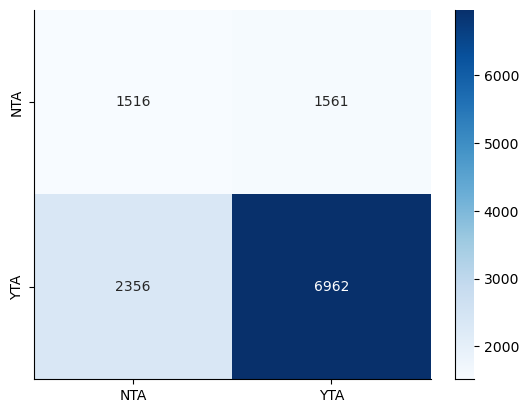

In [9]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(true_labels, preds)

sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["NTA", "YTA"], yticklabels=["NTA", "YTA"])
sns.despine()